In [24]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPool2D,MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image


In [15]:
#Getting the dataset
!wget http://upscfever.com/datasets/flowers-new.zip
#Unzipping the dataset
!unzip -q flowers-new.zip #-q is specified to remove the info displayed for each image


y
--2020-12-10 06:33:47--  http://upscfever.com/datasets/flowers-new.zip
Resolving upscfever.com (upscfever.com)... 104.27.176.133, 172.67.193.2, 104.27.177.133, ...
Connecting to upscfever.com (upscfever.com)|104.27.176.133|:80... connected.
HTTP request sent, awaiting response... y
y
y
y
301 Moved Permanently
Location: https://upscfever.com/datasets/flowers-new.zip [following]
--2020-12-10 06:33:48--  https://upscfever.com/datasets/flowers-new.zip
Connecting to upscfever.com (upscfever.com)|104.27.176.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘flowers-new.zip.2’

flowers-new.zip.2       [          <=>       ]   5.74M  2.78MB/s    in 2.1s    

2020-12-10 06:33:51 (2.78 MB/s) - ‘flowers-new.zip.2’ saved [6021364]

replace flowers/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace flowers/daisy/11642632_1e7627a2cc.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace flowers/daisy/

In [33]:
#Defining a function to generate more data with slight variations for training
def gen_data(flower):
  label = flower
  path = '/content/flowers/' + flower
  img_list = os.listdir(path)
  for img in img_list:
    img = cv2.imread(path + '/' + img)
    img = img.reshape((1,) + img.shape) 

    augment = ImageDataGenerator(rescale = 1./255, zoom_range = 0.1, 
                             height_shift_range = 0.1, shear_range = 5, rotation_range = 5,
                             horizontal_flip = True)

    i = 0
    for batch in augment.flow(img, batch_size = 1, save_to_dir = path + '/', save_prefix = 'gen', 
                        save_format = 'jpeg'):
      i = i+1
      if i == 10: break

In [34]:
#Defining a function to compile our dataset since our data is in different folders
x = []
y = []
def compile_data(flower):
  label = flower
  
  path = '/content/flowers/' + flower
  img_list = os.listdir(path)
  for img in img_list:
    img = cv2.imread(path + '/' + img)
    img = cv2.resize(img, (256, 256))
    x.append(img)
    y.append(label)

In [35]:
#Generating more data for each flower
gen_data('daisy')
gen_data('dandelion')
gen_data('rose')
gen_data('sunflower')
gen_data('tulip')

In [36]:
#Compiling all the data
compile_data('daisy')
compile_data('dandelion')
compile_data('rose')
compile_data('sunflower')
compile_data('tulip')

In [37]:
#Converting all the images into NumPy Array, Reshaping then Scaling
x = np.array(x)
x = np.reshape(x, (len(x), 256*256*3))
x = x/255
np.shape(x)

(1272, 196608)

In [38]:
#Converting all the flowers into labels
LE = LabelEncoder()
y = LE.fit_transform(y)
y = to_categorical(y)
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [39]:
x = np.reshape(x, (np.shape(x)[0], 256, 256, 3))

In [40]:
#Splitting into Train-Test Sets and Setting random seeds
seed = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [41]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (256,256,3)))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(218, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))

In [42]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.05, patience = 10, mode = 'max', restore_best_weights = True)

In [43]:
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0

In [44]:
history = model.fit(x_train,y_train , batch_size=10 ,epochs = 10 , validation_split=0.2 ,callbacks = [learning_rate_reduction])

Epoch 1/10
82/82 [==============================] - 116s 1s/step - loss: 1.3471 - accuracy: 0.5572 - val_loss: 0.6634 - val_accuracy: 0.7500
Epoch 2/10
82/82 [==============================] - 116s 1s/step - loss: 0.5351 - accuracy: 0.8032 - val_loss: 0.6329 - val_accuracy: 0.8186
Epoch 3/10
82/82 [==============================] - 116s 1s/step - loss: 0.2840 - accuracy: 0.9102 - val_loss: 0.3331 - val_accuracy: 0.9118
Epoch 4/10
82/82 [==============================] - 116s 1s/step - loss: 0.3465 - accuracy: 0.8942 - val_loss: 0.3227 - val_accuracy: 0.8873
Epoch 5/10
82/82 [==============================] - 116s 1s/step - loss: 0.0842 - accuracy: 0.9754 - val_loss: 0.1330 - val_accuracy: 0.9657
Epoch 6/10
82/82 [==============================] - 116s 1s/step - loss: 0.0524 - accuracy: 0.9791 - val_loss: 0.1978 - val_accuracy: 0.9657
Epoch 7/10
82/82 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9680
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0

In [45]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

8/8 [==============================] - 7s 889ms/step - loss: 0.2931 - accuracy: 0.9765
Loss of the model is -  0.2931431531906128
8/8 [==============================] - 7s 886ms/step - loss: 0.2931 - accuracy: 0.9765
Accuracy of the model is -  97.64705896377563 %


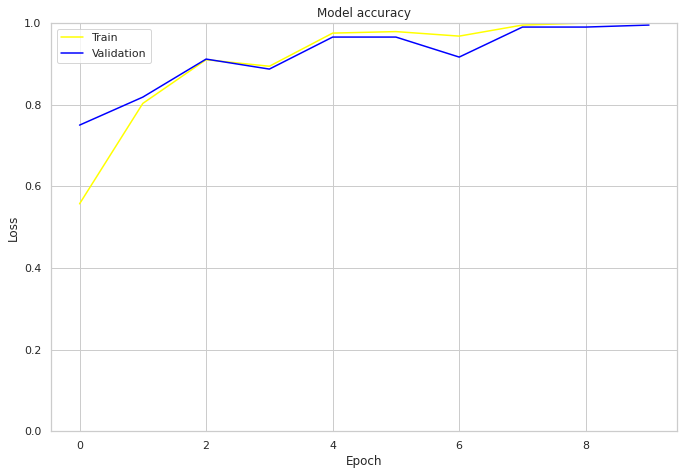

In [46]:
plt.figure(figsize = (10,7))
plt.plot(history.history['accuracy'], color = 'yellow')
plt.plot(history.history['val_accuracy'], color = 'blue')
plt.ylim((0,1))
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [47]:
import tensorflow as tf

tf.keras.models.save_model(model,'h51')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: h51/assets
